In [1]:
import os

import geopandas as gpd
import pandas as pd
import numpy as np
import momepy as mm
import networkx as nx

from sqlalchemy import create_engine

import matplotlib.pyplot as plt
from mapclassify import greedy

user = os.environ.get('DB_USERNAME')
pwd = os.environ.get('DB_PASSWORD')
host = os.environ.get('DB_HOSTNAME')
port = os.environ.get('DB_PORT')

url = f"postgres+psycopg2://{user}:{pwd}@{host}:{port}/geodemo"
engine = create_engine(url)

In [2]:
from shapely.geometry import Point, MultiLineString, MultiPolygon
from shapely.ops import split

In [3]:
def pgselect(table, buffer=100, x=338157, y=393037):
    sql = f'''
    SELECT * FROM {table} 
    WHERE ST_DWithin(geometry, ST_SetSRID(ST_Point({x}, {y}), 27700), {buffer})'''
    return gpd.read_postgis(sql, engine, geom_col='geometry')

In [4]:
def encircle(geometry, circle):
    # if geometry is polygon
    if geometry.type == 'Polygon':
        return MultiPolygon([p for p in list(split(geometry, circle.boundary)) 
                         if circle.buffer(1).contains(p)])
    if geometry.type == 'LineString':
        return MultiLineString([p for p in list(split(geometry, circle.boundary)) 
                         if circle.buffer(1).contains(p)])
    

In [5]:
rds = pgselect('openroads')
bgs = pgselect('openmaplocal')
pn = pgselect('openuprn')
rwy = pgselect('railways')
encs = pgselect('enclosures')

In [7]:
encs

,geometry
0,"POLYGON Z ((338074.010 393629.490 0.000, 33810..."


In [9]:
t=encs.iloc[0].geometry

In [10]:
z = t.centroid
circle = z.buffer(800)

sliced = encs.geometry.apply(lambda x: encircle(x, circle))
esliced = gpd.GeoDataFrame(geometry=sliced)
these = esliced.loc[~esliced.geometry.apply(lambda x: x.is_empty)]

these['c'] = greedy(these)

In [11]:
trds = rds.loc[rds.geometry.apply(lambda x: t.buffer(1).contains(x))]
tbgs = bgs.loc[bgs.geometry.apply(lambda x: t.contains(x))]
tpn = pn.loc[pn.geometry.apply(lambda x: t.contains(x))]

In [12]:
trds = trds.loc[trds.roadFunction!='Secondary Access Road']

In [13]:
boundary = gpd.GeoDataFrame(geometry=gpd.GeoSeries(t.boundary))

/opt/conda/lib/python3.8/site-packages/geopandas/plotting.py:678: UserWarning: The GeoDataFrame you are attempting to plot is empty. Nothing has been displayed.
  warnings.warn(


(337967.7, 338282.3, 392870.29999999993, 393215.7)

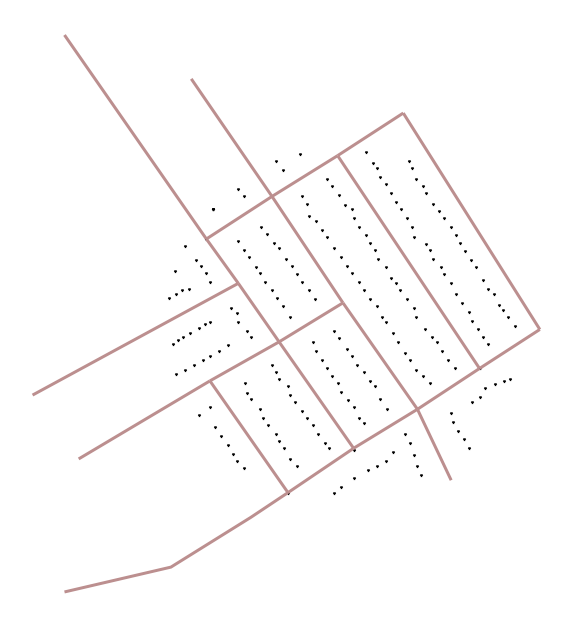

In [15]:
plt.rc('legend',fontsize=15) 
fig, ax = plt.subplots(figsize=(10,20))
these.iloc[3:4].plot(color='bisque', ax=ax)
trds.plot(ax=ax, linewidth=3, legend=True, color='rosybrown')
# tbgs.plot(ax=ax, color='gray')
tpn.plot(ax=ax, color='k', markersize=10, marker='1')
# boundary.plot(color='k', linewidth=5, ax=ax)
plt.axis('off')

In [12]:
trds.roadFunction.value_counts()

Local Road                      185
A Road                           32
Restricted Local Access Road     16
Secondary Access Road            12
Name: roadFunction, dtype: int64

In [13]:
len(tpn)

3702

In [26]:
len(trds.name1.unique())

69

In [27]:
class Neighbourhood:
    def __init__(self):
        pass
    

In [28]:
## colouring face-blocks

In [34]:
def closest_road(pt_row):
    t0 = time.time()
    rd_df= trds
    # for each points row
    # get point id
    pt_it = pt_row.UPRN
    # get distance to all roads,
    dfdict = dict()
    for i in range(len(rd_df)):
        rd_row = rd_df.iloc[i]
        dfdict[i] = dict()
        dfdict[i]['rd_id'] = rd_row.id
        dfdict[i]['distance'] = pt_row.geometry.distance(rd_row.geometry)
    t1 = time.time()
    print(t1-t0)
    return pd.DataFrame(dfdict).T.sort_values('distance').iloc[0].values[0]

In [31]:
import time

In [35]:
tpn[['nearest_rd']]=tpn.apply(closest_road,axis=1)
trds['color'] = trds.index
mapper = {d[1]:d[0] for d in dict(trds.id.T).items()}
tpn['color'] = tpn.nearest_rd.apply(lambda x: mapper[x])